In [1]:
from jax import config 
config.update("jax_enable_x64", True)


import jax 
import jax.numpy as jnp 
import numpy as np 
import pandas as pd
import pymanopt
from matplotlib import pyplot as plt
from kernels import SphereMaternKernel
from models import Prior, GaussianLikelihood, Posterior
import seaborn as sns
from models import deep_negative_elbo
from jaxtyping import Float, Array
import tensorflow_probability.substrates.jax.distributions as tfd
import optax 
from jaxtyping import Key 
from dataclasses import dataclass
from gpjax.base import Module, static_field
from collections.abc import Callable

/home/kacperwyrwal/miniconda3/envs/mdgp-jax2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
@dataclass 
class GammaHyperprior(Module):
    alpha: float = static_field() # concentration
    beta: float = static_field() # rate
    closure: Callable[[], Float[Array, ""]] = static_field()

    distribution: tfd.Gamma = static_field(init=False)

    def __post_init__(self):
        assert self.alpha > 0, "alpha must be positive"
        assert self.beta > 0, "beta must be positive"
        self.distribution = tfd.Gamma(self.alpha, self.beta)

    def log_prob(self) -> Float[Array, ""]:
        return self.distribution.log_prob(self.closure())
    

@jax.jit
def negative_conjugate_marginal_log_likelihood(
    Kxx, y, sigma_squared, jitter: float = 1e-12,
) -> Float[Array, ""]:
    covariance = Kxx.at[jnp.diag_indices_from(Kxx)].add(sigma_squared)
    covariance = covariance.at[jnp.diag_indices_from(covariance)].add(jitter)
    py = tfd.MultivariateNormalFullCovariance(
        loc=jnp.zeros_like(y), covariance_matrix=covariance,
    )
    return -1.0 * py.log_prob(y)


def negative_conjugate_marginal_log_likelihood_with_hyperpriors(
    Kxx, y, sigma_squared, *, jitter: float = 1e-12, priors: list[GammaHyperprior],
) -> Float[Array, ""]:
    return negative_conjugate_marginal_log_likelihood(Kxx, y, sigma_squared, jitter) + sum(
        [prior.log_prob() for prior in priors]
    )

In [3]:
from beartype.typing import (
    Any,
    Callable,
    Optional,
    Tuple,
    TypeVar,
    Union,
)
import jax
from jax import (
    jit,
    value_and_grad,
)
from jax.flatten_util import ravel_pytree
import scipy

from gpjax.base import Module
from gpjax.dataset import Dataset
from gpjax.objectives import AbstractObjective
from gpjax.scan import vscan
from gpjax.typing import (
    ScalarFloat,
)

ModuleModel = TypeVar("ModuleModel", bound=Module)



def fit_scipy(  # noqa: PLR0913
    *,
    model: ModuleModel,
    objective: Union[AbstractObjective, Callable[[ModuleModel, Dataset], ScalarFloat]],
    x: Float[Array, "N D"], 
    y: Float[Array, "N"],
    max_iters: Optional[int] = 500,
    verbose: Optional[bool] = True,
) -> Tuple[ModuleModel, Array]:
    # Unconstrained space model.
    model = model.unconstrain()

    # Unconstrained space loss function with stop-gradient rule for non-trainable params.
    def loss(model: Module) -> ScalarFloat:
        model = model.stop_gradient()
        return objective(model.constrain(), x, y)

    # convert to numpy for interface with scipy
    x0, scipy_to_jnp = ravel_pytree(model)

    @jit
    def scipy_wrapper(x0):
        value, grads = value_and_grad(loss)(scipy_to_jnp(jnp.array(x0)))
        scipy_grads = ravel_pytree(grads)[0]
        return value, scipy_grads

    history = [scipy_wrapper(x0)[0]]
    result = scipy.optimize.minimize(
        fun=scipy_wrapper,
        x0=x0,
        jac=True,
        callback=lambda X: history.append(scipy_wrapper(X)[0]),
        options={"maxiter": max_iters, "disp": verbose},
    )
    history = jnp.array(history)

    # convert back to pytree and reconstrain
    model = scipy_to_jnp(result.x)
    model = model.constrain()
    return model, history


def fit(
    *,
    model, # TODO change to deep gp 
    objective,
    x: Float, 
    y: Float,
    optim: optax.GradientTransformation,
    key: Key,
    num_iters: int = 100,
):

    # Unconstrained space loss function with stop-gradient rule for non-trainable params.
    def loss(model, x: Float, y: Float, *, key: Key) -> Float:
        model = model.stop_gradient()
        return objective(model.constrain(), x, y, key=key)

    # Unconstrained space model.
    model = model.unconstrain()

    # Initialise optimiser state.
    state = optim.init(model)

    # Mini-batch random keys to scan over.
    iter_keys = jax.random.split(key, num_iters)

    # Optimisation step.
    def step(carry, key):
        model, opt_state = carry
        batch_x, batch_y = x, y

        loss_val, loss_gradient = jax.value_and_grad(loss)(model, batch_x, batch_y, key=key)
        updates, opt_state = optim.update(loss_gradient, opt_state, model)
        model = optax.apply_updates(model, updates)

        carry = model, opt_state
        return carry, loss_val

    # Optimisation loop.
    (model, _), history = vscan(step, (model, state), (iter_keys))

    # Constrained space.
    model = model.constrain()

    return model, history


def fit_exact_shallow_gp(p: Posterior, x, y, *, num_iters: int = 500):

    @jax.jit
    def objective(p: Posterior, x, y):
        kernel = p.prior.kernel
        sigma_squared = p.likelihood.noise_variance

        Kxx = jax.vmap(lambda t1: jax.vmap(lambda t2: kernel(t1, t2))(x))(x)
        return negative_conjugate_marginal_log_likelihood(Kxx, y, sigma_squared)
    
    return fit_scipy(
        model=p,
        objective=objective,
        x=x,
        y=y,
        max_iters=num_iters,
        verbose=True,
    )


def fit_exact_shallow_gp_with_hyperpriors(p: Posterior, x, y, *, num_iters: int = 500, priors: list[GammaHyperprior]):

    @jax.jit
    def objective(p: Posterior, x, y):
        kernel = p.prior.kernel
        sigma_squared = p.likelihood.noise_variance

        Kxx = jax.vmap(lambda t1: jax.vmap(lambda t2: kernel(t1, t2))(x))(x)

        noise_prior = GammaHyperprior(alpha=1.1, beta=0.05, closure=lambda: p.likelihood.noise_variance)
        variance_prior = GammaHyperprior(alpha=2.0, beta=0.15, closure=lambda: p.prior.kernel.variance)

        return negative_conjugate_marginal_log_likelihood(Kxx, y, sigma_squared) + noise_prior.log_prob() + variance_prior.log_prob()


        return negative_conjugate_marginal_log_likelihood_with_hyperpriors(Kxx, y, sigma_squared, priors=priors)
    
    return fit_scipy(
        model=p,
        objective=objective,
        x=x,
        y=y,
        max_iters=num_iters,
        verbose=True,
    )

# Expected Improvement

In [4]:
import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import jit
import tensorflow_probability.substrates.jax as tfp


# Define constants
_neg_inv_sqrt2 = -1.0 / jnp.sqrt(2.0)
_log_sqrt_pi_div_2 = jnp.log(jnp.sqrt(jnp.pi / 2))

@jit
def _ei_helper(u: jnp.ndarray) -> jnp.ndarray:
    """Computes phi(u) + u * Phi(u) where phi and Phi are the standard normal pdf and cdf."""
    return norm.pdf(u) + u * norm.cdf(u)

@jax.jit
def _log_abs_u_Phi_div_phi(u: jnp.ndarray) -> jnp.ndarray:
    """Computes log(abs(u) * Phi(u) / phi(u)) for u < 0 in a numerically stable way."""
    # Use the erfcx function from JAX for the scaled complementary error function
    a, b = _neg_inv_sqrt2, _log_sqrt_pi_div_2
    return jnp.log(tfp.math.erfcx(a * u) * jnp.abs(u)) + b

@jax.jit
def log1mexp(x: jnp.ndarray) -> jnp.ndarray:
    """Numerically accurate evaluation of log(1 - exp(x)) for x < 0."""
    log2 = jnp.log(2)
    is_small = -log2 < x
    return jnp.where(
        is_small, 
        jnp.log(-jnp.expm1(x)),
        jnp.log1p(-jnp.exp(x)), 
    )

@jax.jit
def _log_ei_helper(u: jnp.ndarray) -> jnp.ndarray:
    """Computes log(phi(u) + u * Phi(u)) for a wide range of u values in a numerically stable way."""

    bound = -1.0
    neg_inv_sqrt_eps = -1e6  # Double precision

    # Case 1: u > bound
    jnp.mask_indices
    u_upper = jnp.where(u < bound, bound, u)
    log_ei_upper = jnp.log(_ei_helper(u_upper))

    # Case 2: u <= bound
    u_lower = jnp.where(u > bound, bound, u)
    u_eps = jnp.where(u_lower < neg_inv_sqrt_eps, neg_inv_sqrt_eps, u_lower)
    w = _log_abs_u_Phi_div_phi(u_eps)
    log_ei_lower = norm.logpdf(u_lower) + (
        jnp.where(
            u_lower > neg_inv_sqrt_eps,
            log1mexp(w),
            -2.0 * jnp.log(jnp.abs(u_lower)),
        )
    )

    return jnp.where(u > bound, log_ei_upper, log_ei_lower)


@jax.jit
def log_expected_improvement(
    mean: jnp.ndarray, 
    sigma_squared: jnp.ndarray, 
    f_best: float
) -> jnp.ndarray:
    """Computes the logarithm of the expected improvement in a numerically stable way."""
    sigma = jnp.sqrt(sigma_squared)
    
    # Compute the improvement over the best observed value
    z = -(mean - f_best) / sigma
    
    # Use _log_ei_helper to compute the log of the expected improvement
    return _log_ei_helper(z) + jnp.log(sigma)


@jax.jit 
def expected_improvement(
    mean: Float[Array, "N"], 
    sigma_squared: Float[Array, ""], 
    f_best: Float[Array, ""]
) -> Float[Array, "N"]:

    return log_expected_improvement(mean, sigma_squared, f_best)

In [5]:
from pymanopt.manifolds.sphere import Sphere as PymanoptSphere


class Sphere(PymanoptSphere):
    def random(self, n: int, *, key: Key):
        dim = self.dim + 1
        x = jax.random.normal(key, (n, dim))
        return x / jnp.linalg.norm(x, axis=-1, keepdims=True)



from pymanopt.manifolds.manifold import Manifold
from collections.abc import Callable


def acquire_initial_obsevations(
    objective: Callable[[Float[Array, "N D"]], Float[Array, "N"]], 
    *, 
    manifold: Sphere, 
    n: int = 5,
    key: Key,
) -> None:
    x = manifold.random(n, key=key)
    y = objective(x)
    return x, y


def optimize_acquisition_function(
    acquisition_function: Callable[[Float[Array, "N D"]], Float[Array, "N"]], 
    *, 
    manifold: Manifold,
    initial_point: Float[Array, "D"] | None = None
) -> Float[Array, "D"]:
    @pymanopt.function.jax(manifold)
    def cost(t):
        return -acquisition_function(t)

    problem = pymanopt.Problem(manifold=manifold, cost=cost)
    optimizer = pymanopt.optimizers.SteepestDescent(
        verbosity=0,
        max_iterations=100,
    )
    result = optimizer.run(problem, initial_point=initial_point)
    return result.point

In [6]:
import warnings

def initialize_q_batch(X: Float[Array, "N D"], Y: Float[Array, "N"], n: int, *, key: Key):
    n_samples = X.shape[0]
    if n > n_samples:
        raise RuntimeError(f"n ({n}) cannot be larger than the number of provided samples ({n_samples})")
    elif n == n_samples:
        return X

    Ystd = jnp.std(Y)
    if jnp.any(Ystd == 0):
        warnings.warn("All acquisition values for raw samples points are the same.")

        return X[jax.random.choice(key, a=n_samples, shape=(n,), replace=False)]
        raise ValueError("All acquisition values for raw samples points are the same.")

    max_idx = jnp.argmax(Y, axis=0)
    Z = (Y - jnp.mean(Y, axis=0)) / Ystd

    # weights = jnp.exp(etaZ)
    # while jnp.any(jnp.isinf(weights)):
    #     etaZ *= 0.5
    #     weights = jnp.exp(etaZ)
    idcs = jax.random.choice(key=key, a=n_samples, shape=(n,), replace=False, p=jnp.exp(Z))
    idcs = jnp.astype(idcs, jnp.int64)

    # make sure we get the maximum
    if max_idx not in idcs:
        idcs = idcs.at[-1].set(max_idx)
    print(X[max_idx], Y[max_idx])
    return X[idcs]

In [7]:
# 1. Generate points to start optimising the acquisition function from
def generate_initial_conditions(
    acquisition_function: Callable[[Float[Array, "N D"]], Float[Array, "N"]],
    *,
    manifold: Sphere,
    key: Key,
    num_restarts: int = 5,
    raw_samples: int = 100,
) -> Float[Array, "N D"]:
    x = manifold.random(raw_samples, key=key)
    y = jax.vmap(acquisition_function)(x)
    return initialize_q_batch(x, y, num_restarts, key=key)


def generate_initial_conditions__deep_gp(
    acquisition_function: Callable[[Float[Array, "N D"]], Float[Array, "N"]],
    *,
    manifold: Sphere,
    key: Key,
    num_restarts: int = 5,
    raw_samples: int = 100,
) -> Float[Array, "N D"]:
    print("Generating initial conditions")
    x = manifold.random(raw_samples, key=key)
    print(x.shape)
    y = acquisition_function(x)
    print("Initialising conditions generated")
    return initialize_q_batch(x, y, num_restarts, key=key)


# 2. Generate candidates to evaluate the acquisition function at
def generate_candidates(
    initial_conditions: Float[Array, "N D"],
    acquisition_function: Callable[[Float[Array, "N D"]], Float[Array, "N"]],
    *, 
    manifold: Sphere,
) -> tuple[Float[Array, "N D"], Float[Array, "N"]]:
    x = []
    for initial_point in initial_conditions:
        x.append(optimize_acquisition_function(acquisition_function, manifold=manifold, initial_point=initial_point))
    x = jnp.array(x)
    y = jax.vmap(acquisition_function)(x)
    return x, y


# 3. Take the best candidate according to the acquisition function
def optimize_acquisition_function_batch(
    acquisition_function: Callable[[Float[Array, "N D"]], Float[Array, "N"]], 
    *, 
    manifold: Manifold,
    initial_points: Float[Array, "N D"] | None = None
) -> Float[Array, "D"]:
    x, y = generate_candidates(initial_points, acquisition_function, manifold=manifold)
    best_idx = jnp.argmax(y)
    return x[best_idx]


def expected_improvement__exact_gp(
    p: Posterior, 
    x: Float[Array, "N D"], 
    y: Float[Array, "N"], 
    y_best: Float[Array, ""]
) -> Callable[[Float[Array, "D"]], Float[Array, ""]]:
    
    @jax.jit 
    def f(t: Float[Array, "D"]) -> Float[Array, ""]:
        mean, variance = p.moments(t, x, y)
        return expected_improvement(mean, variance, y_best)
    
    return f

In [8]:
from utils import car_to_sph, sph_to_car


def Y_23(sph: Float[Array, "N D"]) -> Float[Array, "N"]:
    colat, lon = sph[:, 0], sph[:, 1]
    return jnp.sqrt(35 / (96 * jnp.pi)) * 3 * jnp.sin(colat) ** 2 * jnp.cos(colat) * jnp.cos(2 * lon)


def target_f(car: Float[Array, "N D"]) -> Float[Array, "N"]:
    def phi(x):
        sph = car_to_sph(x)
        return jnp.stack([sph[:, 1], sph[:, 0]], axis=-1)
    return Y_23(phi(car)) * (car[..., 2] + 1) * (1 - jnp.arccos(car[..., 2]))


manifold = Sphere(3)


def objective(car: Float) -> Float:
    car = jnp.atleast_2d(car)
    return target_f(car)

In [9]:
from utils import sph_to_car, car_to_sph


import matplotlib.colors as mcolors
import os 
import tensorflow_probability.substrates.jax.bijectors as tfb




def run_bayesian_optimization__exact_gp(
    objective: Callable[[Float[Array, "N D"]], Float[Array, "N"]], 
    *, 
    manifold: Manifold, 
    bo_iters: int = 200,
    fit_iters: int = 500, 
    n_initial_observations: int = 5,
    num_restarts: int = 5,
    raw_samples: int = 100,
    plot_iters: int = 10,
    seed: int,
) -> None:
    key = jax.random.key(seed)

    results_x_path = f"results_x-{seed=}.npy"
    results_y_path = f"results_y-{seed=}.npy"

    if os.path.exists(results_x_path) and os.path.exists(results_y_path):
        x = jnp.load(results_x_path)
        y = jnp.load(results_y_path)
        start_iter = x.shape[0] - 1 - n_initial_observations
        print("Resuming from previous results at iteration", start_iter)
        key, initial_key = jax.random.split(key)
    else:
        # acquire initial observations
        key, initial_key = jax.random.split(key)
        x, y = acquire_initial_obsevations(objective, manifold=manifold, n=n_initial_observations, key=initial_key)
        start_iter = 0
        print("Starting from scratch")

    idx_best = jnp.argmin(y)
    x_best, y_best = x[idx_best], y[idx_best]
    x_bests, y_bests = jnp.array([x_best]), jnp.array([y_best])

    iter_keys = jax.random.split(key, bo_iters)
    for bo_iter_num, iter_key in enumerate(iter_keys):
        if bo_iter_num < start_iter:
            continue 
        
        # fit gp to data
        kernel = SphereMaternKernel(sphere_dim=2, nu=jnp.array(2.5))
        kernel = kernel.replace_trainable(nu=False)
        noise_prior = GammaHyperprior(
            alpha=1.1, 
            beta=0.05, 
            closure=lambda: p.likelihood.noise_variance,
        )
        noise_prior_mode = (noise_prior.alpha - 1) / noise_prior.beta
        sigma_squared_prior = GammaHyperprior(
            alpha=2.0, 
            beta=0.15, 
            closure=lambda: p.prior.kernel.variance,
        )
        likelihood = GaussianLikelihood(
            noise_variance=noise_prior_mode,
        )
        likelihood = likelihood.replace_bijector(noise_variance=tfb.Chain([tfb.Shift(1e-8), tfb.Softplus()]))
        p = Posterior(
            prior=Prior(kernel=kernel),
            likelihood=likelihood,
        )



        priors = [noise_prior, sigma_squared_prior]
        p, _ = fit_exact_shallow_gp_with_hyperpriors(p, x, y, num_iters=fit_iters, priors=priors)
        # p, _ = fit_exact_shallow_gp(p, x, y, optimizer=optimizer, key=iter_key, num_iters=fit_iters)

        # acquire new point 
        ei = expected_improvement__exact_gp(p, x, y, y_best)
        initial_conditions = generate_initial_conditions(ei, manifold=manifold, key=iter_key, num_restarts=num_restarts, raw_samples=raw_samples)
        x_new = optimize_acquisition_function_batch(ei, manifold=manifold, initial_points=initial_conditions)
        y_new = objective(x_new)

        # update data
        x = jnp.vstack([x, x_new])
        y = jnp.concat([y, y_new])
        if y_new < y_best:
            y_best = y_new.item()
            x_best = x_new
        x_bests = jnp.vstack([x_bests, x_best])
        y_bests = jnp.concat([y_bests, jnp.asarray(y_best)[None]])

        print(bo_iter_num, x_new, y_new, x_best, y_best)

        # save partial results
        jnp.save(results_x_path, x)
        jnp.save(results_y_path, y)
        
        if plot_iters is not None and bo_iter_num % plot_iters == 0:
            print("Plotting prediction")
            colat = jnp.linspace(0, jnp.pi, 100)
            lon = jnp.linspace(0, 2 * jnp.pi, 100)
            colat, lon = jnp.meshgrid(colat, lon)
            t = sph_to_car(jnp.stack([colat.ravel(), lon.ravel()], axis=-1))
            m, v = jax.vmap(lambda t1: p.moments(t1, x, y))(t)
            s = jnp.sqrt(v)
            ei = jax.vmap(lambda t1: ei(t1))(t)
            y_true = objective(t)


            vmin = min(np.min(y), np.min(m), np.min(y_true))
            vmax = max(np.max(y), np.max(m), np.max(y_true))
            norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
            cmap = plt.cm.viridis

            fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
            ax1.pcolormesh(colat, lon, y_true.reshape(colat.shape), cmap=cmap, norm=norm)
            
            ax2.pcolormesh(colat, lon, m.reshape(colat.shape), cmap=cmap, norm=norm)
            x_sph = car_to_sph(x)
            ax2.scatter(x_sph[:, 0], x_sph[:, 1], c=y, cmap=cmap, norm=norm, edgecolors='white')

            ax3.pcolormesh(colat, lon, s.reshape(colat.shape), cmap='magma')

            ax4.pcolormesh(colat, lon, ei.reshape(colat.shape), cmap='plasma')

            fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=[ax1, ax2, ax3, ax4])

            plt.show()

            # t = jnp.linspace(jnp.min(x), jnp.max(x), 1000)[:, None]
            # plot_prediction__exact_gp(p, x, y, t)
            # plt.show()
        
    return x_bests, y_bests

# Now fit a coordinate frame residual deep GP

In [10]:
from jax.tree_util import Partial 
from dataclasses import dataclass 
from gpjax.base import Module, param_field, static_field
import tensorflow_probability.substrates.jax.bijectors as tfb
from kernels import MultioutputSphereMaternKernel
from models import inducing_points_prior_kl, MultioutputInducingPointsPosterior, InducingPointsPosterior, kmeans_inducing_points, MultioutputPrior, MultioutputDummyPosterior, DeepGaussianLikelihood
from utils import tangent_basis, sphere_expmap, num_phases_to_num_levels

In [11]:
@dataclass 
class CoordinateFrameResidualDeepGP(Module):
    hidden_layers: list[MultioutputInducingPointsPosterior] = param_field()
    output_layer: InducingPointsPosterior = param_field()
    num_samples: int = static_field(1)

    @property 
    def posterior(self) -> Posterior:
        return self.output_layer.posterior      
    
    def prior_kl(self) -> Float:
        return sum(layer.prior_kl() for layer in self.hidden_layers) + self.output_layer.prior_kl()
    
    def sample_moments(self, x: Float[Array, "N 3"], *, key: Key) -> tfd.Normal:

        @jax.jit
        @Partial(jax.vmap, in_axes=(0, 0))
        def vector_from_coordinate_frame(x: Float[Array, "3"], v: Float[Array, "2"]) -> Float[Array, "3"]:
            return tangent_basis(car_to_sph(x)) @ v

        hidden_layer_keys = jax.random.split(key, len(self.hidden_layers))
        for hidden_layer_key, layer in zip(hidden_layer_keys, self.hidden_layers):
            v = layer.diag(x).sample(seed=hidden_layer_key)
            u = vector_from_coordinate_frame(x, v)
            x = sphere_expmap(x, u)
        return jax.vmap(self.output_layer.moments)(x)
    
    def moments(self, t: Float[Array, "N 3"], x=None, y=None) -> tfd.Normal:
        key = jax.random.key(0)
        return self.sample_moments(t, key=key)
    
    def sample_pathwise_moments(self, x: Float[Array, "N 3"], *, key: Key) -> Float[Array, "N"]:
        squeeze_output = x.ndim == 1
        x = jnp.atleast_2d(x)

        @jax.jit
        @Partial(jax.vmap, in_axes=(0, 0))
        def vector_from_coordinate_frame(x: Float[Array, "3"], v: Float[Array, "2"]) -> Float[Array, "3"]:
            return tangent_basis(car_to_sph(x)) @ v

        hidden_layer_keys = jax.random.split(key, len(self.hidden_layers))
        for hidden_layer_key, layer in zip(hidden_layer_keys, self.hidden_layers):
            v = layer.pathwise_sample(x, key=hidden_layer_key)
            u = vector_from_coordinate_frame(x, v)
            x = sphere_expmap(x, u)
        mean, var = jax.vmap(self.output_layer.moments)(x)

        if squeeze_output:
            mean, var = jnp.squeeze(mean, axis=0), jnp.squeeze(var, axis=0)
        return mean, var

    def diag(self, x: Float[Array, "N D"], *, key: Key) -> tfd.MixtureSameFamily:
        sample_keys = jax.random.split(key, self.num_samples)

        # In MixtureSameFamily batch size goes last; hence, out_axes = 1
        mean, variance = jax.vmap(lambda k: self.sample_moments(x, key=k), out_axes=1)(sample_keys) 

        return tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(logits=jnp.zeros(self.num_samples)), 
            components_distribution=tfd.Normal(loc=mean, scale=jnp.sqrt(variance)), 
        )
    
    def pathwise_diag(self, x: Float[Array, "N D"], *, key: Key) -> tfd.MixtureSameFamily:
        sample_keys = jax.random.split(key, self.num_samples)

        # In MixtureSameFamily batch size goes last; hence, out_axes = 1
        mean, variance = jax.vmap(lambda k: self.sample_pathwise_moments(x, key=k), out_axes=1)(sample_keys) 

        return tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(logits=jnp.zeros(self.num_samples)), 
            components_distribution=tfd.Normal(loc=mean, scale=jnp.sqrt(variance)), 
        )


def create_coordinate_frame_residual_deep_gp_with_inducing_points(
    num_layers: int, total_hidden_variance: float, num_inducing: int, x: Float[Array, "N D"], num_samples: int = 3, *, key: Key, train_inducing: bool = False, 
    nu: float = 1.5, kernel_max_ell: int | None = None
) -> CoordinateFrameResidualDeepGP:
    sphere_dim = x.shape[1] - 1

    hidden_nu = jnp.array(nu)
    output_nu = hidden_nu

    hidden_variance = total_hidden_variance / max(num_layers - 1, 1)
    output_variance = jnp.array(1.0)

    hidden_kappa = jnp.array(1.0)
    output_kappa = hidden_kappa

    z = kmeans_inducing_points(key, x, num_inducing)
    hidden_z = z / jnp.linalg.norm(z, axis=-1, keepdims=True)
    output_z = hidden_z

    if kernel_max_ell is None:
        kernel_max_ell = num_phases_to_num_levels(num_inducing, sphere_dim=sphere_dim)

    hidden_layers = []
    for _ in range(num_layers - 1):
        kernel = MultioutputSphereMaternKernel(
            num_outputs=sphere_dim, 
            sphere_dim=sphere_dim, 
            nu=hidden_nu,
            kappa=hidden_kappa,
            variance=hidden_variance,
            max_ell=kernel_max_ell,
        )
        prior = MultioutputPrior(kernel=kernel)
        posterior = MultioutputDummyPosterior(prior=prior)
        layer = MultioutputInducingPointsPosterior(posterior=posterior, z=hidden_z) # TODO set z to be trainable maybe 
        hidden_layers.append(layer)

    kernel = SphereMaternKernel(
        sphere_dim=sphere_dim,
        nu=output_nu,
        kappa=output_kappa,
        variance=output_variance,
        max_ell=kernel_max_ell,
    )
    prior = Prior(kernel=kernel)
    likelihood = DeepGaussianLikelihood()
    posterior = Posterior(prior=prior, likelihood=likelihood)
    output_layer = InducingPointsPosterior(posterior=posterior, z=output_z)
    if train_inducing:
        output_layer = output_layer.replace_trainable(z=True)

    return CoordinateFrameResidualDeepGP(hidden_layers=hidden_layers, output_layer=output_layer, num_samples=num_samples)

In [12]:
def expected_improvement__deep_gp(
    p: CoordinateFrameResidualDeepGP, 
    x: Float[Array, "N D"], 
    y: Float[Array, "N"], 
    y_best: Float[Array, ""],
    *,
    key: Key, 
    
) -> Callable[[Float[Array, "D"]], Float[Array, ""]]:

    
    @jax.jit 
    def f(t: Float[Array, "D"]) -> Float[Array, ""]:
        sample_keys = jax.random.split(key, p.num_samples)

        # In MixtureSameFamily batch size goes last; hence, out_axes = 1
        mean, variance = jax.vmap(lambda k: p.sample_pathwise_moments(t, key=k))(sample_keys) # [K N]

        return jnp.mean(jax.vmap(lambda m, v: expected_improvement(m, v, y_best))(mean, variance), axis=0)
    
    return f


def run_bayesian_optimization__deep_gp(
    objective: Callable[[Float[Array, "N D"]], Float[Array, "N"]], 
    *, 
    manifold: Manifold, 
    optimizer: optax.GradientTransformation,
    start_iter: int = 180,
    bo_iters: int = 200,
    fit_iters: int = 500, 
    n_initial_observations: int = 5,
    num_restarts: int = 5,
    raw_samples: int = 100,
    plot_iters: int = 10,
    seed: int,
) -> None:
    key = jax.random.key(seed)

    results_x_path = f"results_x-{seed=}.npy"
    results_y_path = f"results_y-{seed=}.npy"

    if os.path.exists(results_x_path) and os.path.exists(results_y_path):
        x = jnp.load(results_x_path)
        y = jnp.load(results_y_path)
        saved_bo_iters = x.shape[0] - 1 - n_initial_observations
        print("Resuming from previous results at iteration", start_iter)
        key, initial_key = jax.random.split(key)
        assert saved_bo_iters >= start_iter, (saved_bo_iters, bo_iters)
        x = x[:start_iter + n_initial_observations]
        y = y[:start_iter + n_initial_observations]

    idx_best = jnp.argmin(y)
    x_best, y_best = x[idx_best], y[idx_best]
    x_bests, y_bests = jnp.array([x_best]), jnp.array([y_best])

    iter_keys = jax.random.split(key, bo_iters)
    for bo_iter_num, iter_key in enumerate(iter_keys):
        if bo_iter_num < start_iter:
            continue 
        p = create_coordinate_frame_residual_deep_gp_with_inducing_points(
            num_layers=2, 
            total_hidden_variance=0.01, 
            num_inducing=x.shape[0], 
            x=x, 
            num_samples=3, 
            key=key, 
            train_inducing=False,
            nu=2.5,
            kernel_max_ell=10,
        )

        optimizer = optax.adam(1e-2)
        p, _ = fit(
            model=p, 
            objective=Partial(deep_negative_elbo, n=x.shape[0]),
            optim=optimizer,
            key=iter_key,
            num_iters=fit_iters,
            x=x, 
            y=y, 
        )

        # acquire new point 
        ei = expected_improvement__deep_gp(p, x, y, y_best, key=iter_key)
        initial_conditions = generate_initial_conditions__deep_gp(ei, manifold=manifold, key=iter_key, num_restarts=num_restarts, raw_samples=raw_samples)
        x_new = optimize_acquisition_function_batch(ei, manifold=manifold, initial_points=initial_conditions)
        y_new = objective(x_new)

        # update data
        x = jnp.vstack([x, x_new])
        y = jnp.concat([y, y_new])
        if y_new < y_best:
            y_best = y_new.item()
            x_best = x_new
        x_bests = jnp.vstack([x_bests, x_best])
        y_bests = jnp.concat([y_bests, jnp.asarray(y_best)[None]])

        print(bo_iter_num, x_new, y_new, x_best, y_best)

        # save partial results
        jnp.save(results_x_path, x)
        jnp.save(results_y_path, y)
        
        if plot_iters is not None and bo_iter_num % plot_iters == 0:
            print("Plotting prediction")
            colat = jnp.linspace(0, jnp.pi, 100)
            lon = jnp.linspace(0, 2 * jnp.pi, 100)
            colat, lon = jnp.meshgrid(colat, lon)
            t = sph_to_car(jnp.stack([colat.ravel(), lon.ravel()], axis=-1))

            px = p.pathwise_diag(t, key=key)
            m = px.mean()
            v = px.variance()

            # m, v = jax.vmap(lambda t1: p.moments(t1, x, y))(t)
            s = jnp.sqrt(v)
            ei = jax.vmap(lambda t1: ei(t1))(t)
            y_true = objective(t)


            vmin = min(np.min(y), np.min(m), np.min(y_true))
            vmax = max(np.max(y), np.max(m), np.max(y_true))
            norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
            cmap = plt.cm.viridis

            fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
            ax1.pcolormesh(colat, lon, y_true.reshape(colat.shape), cmap=cmap, norm=norm)
            
            ax2.pcolormesh(colat, lon, m.reshape(colat.shape), cmap=cmap, norm=norm)
            x_sph = car_to_sph(x)
            ax2.scatter(x_sph[:, 0], x_sph[:, 1], c=y, cmap=cmap, norm=norm, edgecolors='white')

            ax3.pcolormesh(colat, lon, s.reshape(colat.shape), cmap='magma')

            ax4.pcolormesh(colat, lon, ei.reshape(colat.shape), cmap='plasma')

            fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=[ax1, ax2, ax3, ax4])

            plt.show()

            # t = jnp.linspace(jnp.min(x), jnp.max(x), 1000)[:, None]
            # plot_prediction__exact_gp(p, x, y, t)
            # plt.show()
        
    return x_bests, y_bests

In [13]:
seed = 1010

# Now fit a deep hodge GP

In [14]:
from ast import literal_eval



xy = pd.read_csv("/home/kacperwyrwal/MDGP/MDGP-all-bo/experiments/bo/target_function_name=perm_sph_harm-model_name=exact-optimize_nu=False-outputscale_mean=0.01-acqf_name=expected_improvement/run_0/bo/all.csv")

# literal eval the x column
xy['x'] = xy['x'].apply(literal_eval)

x, y = xy['x'].values, xy['y'].values
x = np.stack(x)

In [15]:
key = jax.random.key(0)


model = create_coordinate_frame_residual_deep_gp_with_inducing_points(
    num_layers=2, 
    total_hidden_variance=0.01, 
    num_inducing=180, 
    x=x, 
    num_samples=3, 
    key=key, 
    train_inducing=False,
    nu=2.5,
    kernel_max_ell=20,
)

Resuming from previous results at iteration 180


Running: 100%|██████████| 2000/2000 [06:33<00:00,  5.09it/s, Value=-324.39]


Generating initial conditions
(1500, 3)
Initialising conditions generated
[ 0.08409344 -0.02558977  0.99612924] -34.23493374722796
180 [-0.00839215 -0.01058906  0.99990872] [-0.76891926] [-0.00839215 -0.01058906  0.99990872] -0.7689192582868726
Plotting prediction


2024-11-01 09:01:34.592102: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %pad.110 = f64[11,10000,11]{2,1,0} pad(f64[11,10000,1]{2,1,0} %broadcast.5057, f64[] %constant.3095), padding=0_0x0_0x0_10, metadata={op_name="jit(pathwise_sample)/jit(main)/jit(phi)/jit(polynomial_expansion)/jit(gegenbauer)/scatter[update_jaxpr=None update_consts=() dimension_numbers=ScatterDimensionNumbers(update_window_dims=(0, 1), inserted_window_dims=(2,), scatter_dims_to_operand_dims=(2,)) indices_are_sorted=True unique_indices=True mode=GatherScatterMode.FILL_OR_DROP]" source_file="/home/kacperwyrwal/MDGP/manifold-deep-gps/submission/experiments/spherical_harmonics.py" source_line=58}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input p

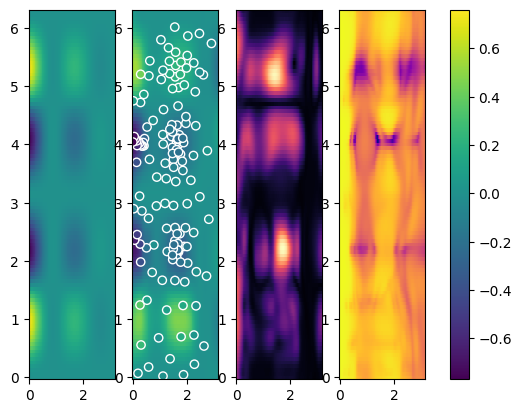

Running: 100%|██████████| 2000/2000 [06:41<00:00,  4.99it/s, Value=-387.06]


Generating initial conditions
(1500, 3)
Initialising conditions generated
[ 0.23240273 -0.09220541  0.96823919] -45.33754813131101
181 [ 0.03058651 -0.01146614  0.99946635] [0.22757201] [-0.00839215 -0.01058906  0.99990872] -0.7689192582868726
Plotting prediction


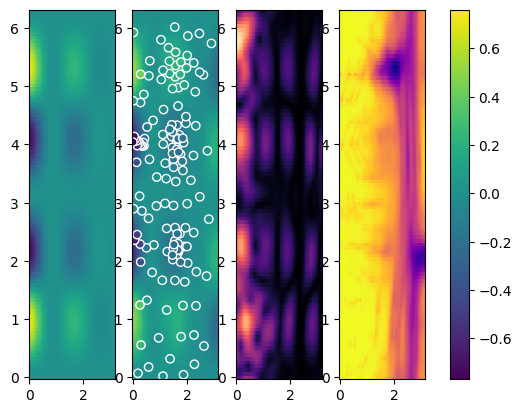

Compiling...:   0%|          | 0/2000 [00:00<?, ?it/s]

In [16]:
run_bayesian_optimization__deep_gp(
    objective, 
    manifold=manifold, 
    optimizer=optax.adam(1e-2),
    start_iter=180,
    bo_iters=200,
    fit_iters=2000,
    n_initial_observations=5,
    num_restarts=5,
    raw_samples=1500,
    plot_iters=1,
    seed=seed,
)